# Práctica 3 de Reconocimiento de Patrones:
## Histograma para generar Vectores de Características

Integrantes:
 - Diego Fernández Chaparro Plata Javier
 - Vargas Castro Daniel
 - Velázquez Sánchez José Antonio
 
### Objetivos
El alumno:
- Aprenderá a calcular el histograma global y local de la Imagen
- Entenderá como calcular la distancia de error entre dos histogramas
 
### Introducción
El histograma es una medida que caracteriza a la imagen de manera muy específica: esta cuantifica todos los pixeles de una imagen de acuerdo a su intensidad. Esta caracterización suele ser especialmente útil para la identificación de superficies y texturas en una imagen; es invariante a rotaciones, y suele captar con precisión las diferencias visuales que percibimos en las mismas.

El objetivo de esta práctica es que conozcamos e implementemos algunos algoritmos que trabajan sobre histogramas. En primera instancia, se solicita hacer una operación convencional a las imagenes, que muchas veces tiene como objetivo remarcar diferencias visuales y mejorar la imagen: la ecualización del histograma. La ecualización de un histograma busca modificar la intensidad de los pixeles de una imagen de manera que la frecuencia sea constante para todas las intensidades. Visualmente, esto se traduce a un proceso de realce de tonos en la imagen. La ecualización del histograma puede hacerse de manera global o local. Es decir, se pueden modificar todos los pixeles de la imagen a partir de un histograma global de la misma, o modificar pixeles de acuerdo con el histograma ecualizado únicamente de una vecindad. Una medida útil para estudiar qué tan similares son los histogramas de dos imagenes es la medida de Chi-cuadrada. Esta medida busca dar un valor numérico que se indique la similitud entre dos histogramas, esto puede servir para el reconocimiento de superficies o identificación de imágenes, por ejemplo.

Una vez familizarizados con algunas operaciones básicas con histogramas, utilizaremos los conocimientos que tenemos de estas operaciones para realizar una clasificación de una parte específica del corazón. Esta parte del corazón suele tener una textura visiblemente distinta al resto de las partes del corazón que aparecen en la imagen, por lo que debería de ser posible atacar el problema utilizando una medida de las texturas: el histograma.

En terminos simples, el objetivo es poder segmentar esta parte del corazón utilizando un clasificador que tome como criterio diversos valores relacionados con la textura de la zona. Esto se hará entrenando un clasificador Bayesiano que tome como entradas ciertos criterios relevantes del histograma de la textura: media, desviación estándar y momoentos, y utilizar esta información, junto con el clasificador que entrenaremos previamente para predecir si un pixel arbitrario de la imagen pertenece a esta parte del corazón que queremos estudiar.

### Desarrollo

In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as parches
from skimage import io
import numpy as np
from random import randint
import cv2
import scipy
import scipy.io as sio
from scipy import signal, stats
import imageio
from matplotlib import gridspec
from sklearn.naive_bayes import GaussianNB
from scipy.misc import imsave
np.set_printoptions(threshold=np.inf)
plt.rcParams['figure.figsize'] = [10, 10]

In [137]:
#Función que convierte todas las imagenes a PNG y les cambia la escala [-1024, 1024] -> [0,255]

nombres_archivos = ["archivos/01_CHAVE.mat","archivos/04_AVILA.mat","archivos/ESTUDIO_1_BOULLOSA.mat","archivos/ESTUDIO_11_ARIASORTIZ.mat"]
nombres_carpetas = ["chavez","avila","boullosa","ariasortiz"]

rangechanger = lambda x : int(round(0.12451171*x + 127.5)) # [-1024, 1024] -> [0, 255]
rangechanger = np.vectorize(rangechanger)

for i in range(len(nombres_archivos)):
    nombre_archivo = nombres_archivos[i]
    nombre_carpeta = nombres_carpetas[i]
    volumenes = sio.loadmat(nombre_archivo)["volumenes"]
    print("Extrayendo archivo: ", nombre_archivo)
    for j in range(volumenes.shape[2]):
        imagen = volumenes[:,:,j]
        imagen_norm = rangechanger(imagen)
        # plt.imshow(imagen_norm, cmap='gray')
        # print("j=", j)
        # plt.show()
        imageio.imwrite("archivos/" + nombre_carpeta + "/" + str(j) + ".png", np.uint8(imagen_norm))

Extrayendo archivo:  archivos/01_CHAVE.mat
Extrayendo archivo:  archivos/04_AVILA.mat
Extrayendo archivo:  archivos/ESTUDIO_1_BOULLOSA.mat
Extrayendo archivo:  archivos/ESTUDIO_11_ARIASORTIZ.mat


#### A) ECUALIZACIÓN GLOBAL

##### Ecualización global, ejemplo

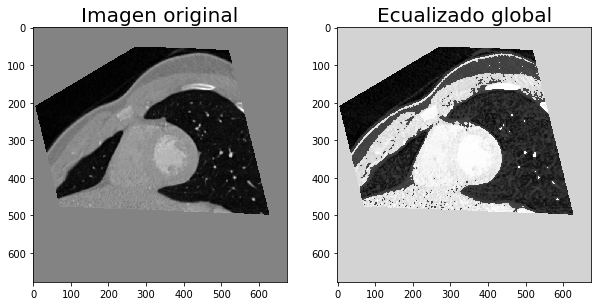

In [146]:
img = cv2.imread("archivos/chavez/1.png",0)
equ = cv2.equalizeHist(img)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img, cmap = "gray")
ax1.set_title("Imagen original",fontsize=20)
ax2.imshow(equ, cmap = "gray")
ax2.set_title("Ecualizado global",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_01_img.png", img)
imageio.imwrite("resultados/A_02_eq-global.png", equ)

##### Implementación de ecualización local

In [140]:
def local_equ(original, patch_size):
    patch_x = patch_size[0]
    patch_y = patch_size[1]
    imagen_x = original.shape[0]
    imagen_y = original.shape[1]
    #plt.imshow(original, cmap='gray')
    #plt.show()
    #print("imagen: ", original)
    for i in range(0, imagen_y - patch_y): # renglones
        for j in range(0, imagen_x - patch_x): # columnas
            patch = original[i:i+patch_y, j:j+patch_x]
            equ = cv2.equalizeHist(patch)
            #print("patch: ", patch)
            #print("equ: ", equ)
            original[i + int(patch_y/2),j + int(patch_x/2)] = equ[int(patch_y/2), int(patch_x/2)]  
    return original
    #plt.imshow(original,cmap="gray")
    #plt.show()

##### Probando con imagen de cuadros

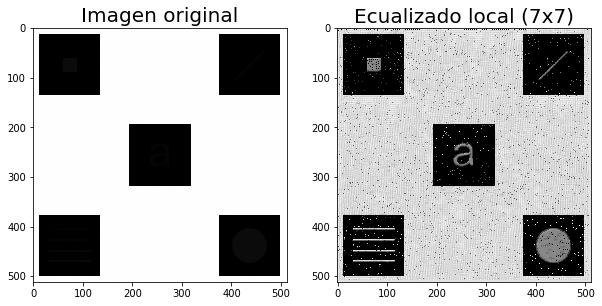

In [147]:
original = cv2.imread("archivos/embedded_square.tif",0)
ec_local = local_equ(np.copy(original), (7,7))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(original, cmap = "gray")
ax1.set_title("Imagen original",fontsize=20)
ax2.imshow(ec_local, cmap = "gray")
ax2.set_title("Ecualizado local (7x7)",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_03_original.png", original)
imageio.imwrite("resultados/A_04_equ-loca.png", ec_local)


##### Probando con imagen de corazón (7x7)

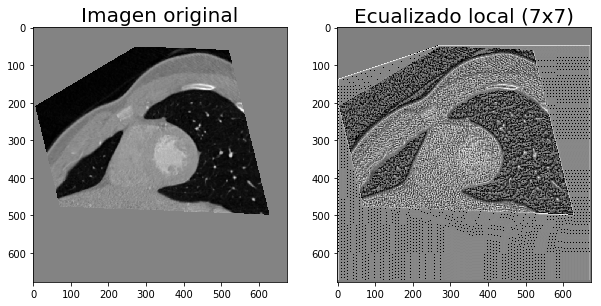

In [148]:
original = cv2.imread("archivos/chavez/1.png",0)
ec_local = local_equ(np.copy(original), (7,7))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(original, cmap = "gray")
ax1.set_title("Imagen original",fontsize=20)
ax2.imshow(ec_local, cmap = "gray")
ax2.set_title("Ecualizado local (7x7)",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_05_original.png", original)
imageio.imwrite("resultados/A_06_equ-loca.png", ec_local)

##### Probando con imagen de corazón (11x11)

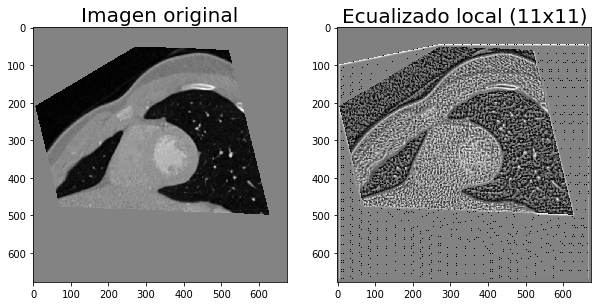

In [149]:
original = cv2.imread("archivos/chavez/1.png",0)
ec_local = local_equ(np.copy(original), (11,11))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(original, cmap = "gray")
ax1.set_title("Imagen original",fontsize=20)
ax2.imshow(ec_local, cmap = "gray")
ax2.set_title("Ecualizado local (11x11)",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_07_original.png", original)
imageio.imwrite("resultados/A_08_equ-loca.png", ec_local)

##### Ecualizado local con ruido

##### 7x7

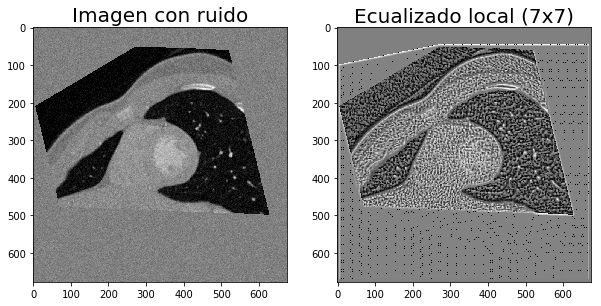

In [150]:
def threshold(x):
    if x > 255:
        return 255
    elif x < 0:
        return 0
    else:
        return int(round(x))

thresholdv = np.vectorize(threshold)
original = cv2.imread("archivos/chavez/1.png",0)
noised = original + np.random.normal(0, 10, original.shape) # Agregamos ruido Gaussiano
noised = thresholdv(noised)
noised_int8 = noised.astype(np.uint8)
ec_local_noised = local_equ(np.copy(noised_int8), (77,7))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(noised, cmap = "gray")
ax1.set_title("Imagen con ruido",fontsize=20)
ax2.imshow(ec_local, cmap = "gray")
ax2.set_title("Ecualizado local (7x7)",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_09_original.png", noised)
imageio.imwrite("resultados/A_10_equ-loca.png", ec_local)

##### (18x18)

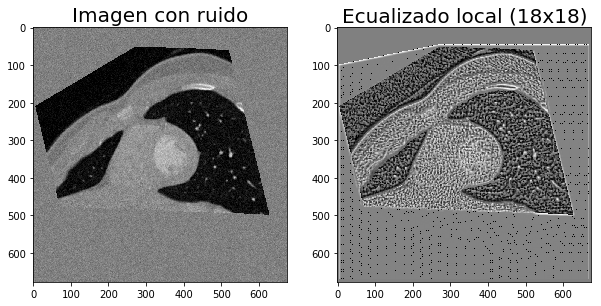

In [151]:
original = cv2.imread("archivos/chavez/1.png",0)
noised = original + np.random.normal(0, 10, original.shape) # Agregamos ruido Gaussiano
noised = thresholdv(noised)
noised_int8 = noised.astype(np.uint8)
ec_local_noised = local_equ(np.copy(noised_int8), (18,18))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(noised, cmap = "gray")
ax1.set_title("Imagen con ruido",fontsize=20)
ax2.imshow(ec_local, cmap = "gray")
ax2.set_title("Ecualizado local (18x18)",fontsize=20)
plt.show()

imageio.imwrite("resultados/A_11_original.png", noised)
imageio.imwrite("resultados/A_12_equ-loca.png", ec_local)

##### Implementando filtro binomial

In [152]:
def pascal(n):
    line = [1]
    for k in range(n):
        line.append(line[k] * (n-k) / (k+1))
    arr = np.array(line)
    return (arr/np.sum(arr))

window_x = 30
window_y = 30
a = pascal(window_x-1)
b = pascal(window_x-1)
a = np.reshape(a, (-1,window_x))
b = np.reshape(b, (-1,window_y))
kernel = np.dot(a.T,b)

##### Histograma imagen original

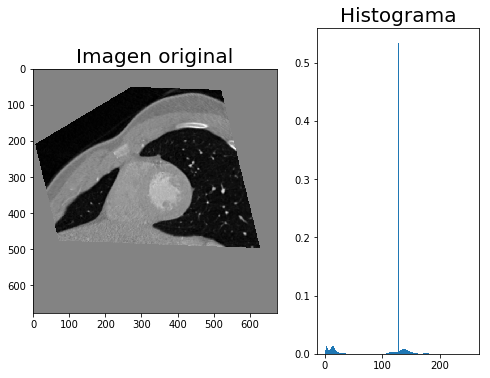

In [153]:
img = cv2.imread("archivos/chavez/1.png",0)
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(img, cmap = "gray")
ax2.hist(img.ravel(), 256, [0,256], density = True)
ax1.set_title("Imagen original",fontsize=20)
ax2.set_title("Histograma",fontsize=20)
plt.show()

##### Histograma imagen filtrada

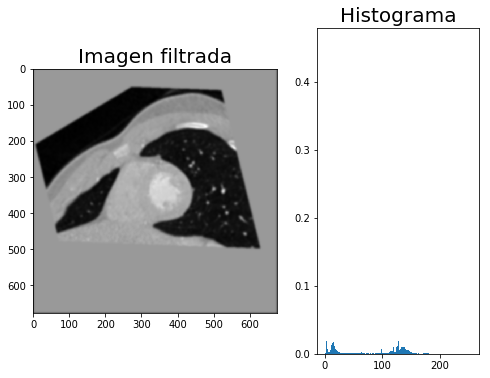

In [154]:
filtrada = signal.convolve2d(img, kernel,mode="same")
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(filtrada, cmap = "gray")
ax2.hist(filtrada.ravel(), 256, [0,256], density = True)
ax1.set_title("Imagen filtrada",fontsize=20)
ax2.set_title("Histograma",fontsize=20)
plt.show()

##### Distancia de Chi-cuadrada

In [155]:
histo_original = np.histogram(img, 256, [0, 256])[0]
histo_filtrada = np.histogram(filtrada, 256, [0, 256])[0]
distancia = 0
for i in range(len(histo_original)):
    xi = histo_original[i]
    yi = histo_filtrada[i]
    #print("xi: ", xi)
    #print("yi: ", yi)
    if(xi == 0 and yi == 0):
        next
    else:
        distancia += ((xi - yi)**2 / (xi+yi))
print("La distancia Chi**2 es: ", distancia)

La distancia Chi**2 es:  448892.42619693634


#### B) HISTOGRAMAS COMO VECTORES DE CARACTERÍSTICAS

##### Reconocimiento mediante análisis del histograma.

In [156]:
#SE CARGAN LAS IMÁGENES AL PROGRAMA.
#Diccionarios con los datos de prueba. Cada diccionario es un paciente: 
#"imgs" lleva a una lista de todas las imágenes.
#"area" es otro diccionario con las coordenadas del rectángulo que enmarca el ventrículo
imgs_prueba1 = {"imgs":[], "area":{}}
imgs_prueba2 = {"imgs":[], "area":{}}
imgs_prueba3 = {"imgs":[], "area":{}}
imgs_prueba4 = {"imgs":[], "area":{}}

#Se carga la serie de imágenes de cada paciente a su diccionario correspondiente.
for i in range(0, 10):
    imgs_prueba1["imgs"].append(io.imread("archivos/ariasortiz/" + str(i) + ".png", as_gray=True))

for i in range(0, 10):
    imgs_prueba2["imgs"].append(io.imread("archivos/avila/" + str(i) + ".png", as_gray=True))
    
for i in range(0, 7):
    imgs_prueba3["imgs"].append(io.imread("archivos/boullosa/" + str(i) + ".png", as_gray=True))

for i in range(1, 10):
    imgs_prueba4["imgs"].append(io.imread("archivos/chavez/" + str(i) + ".png", as_gray=True))

Etiquetado de zonas de interés

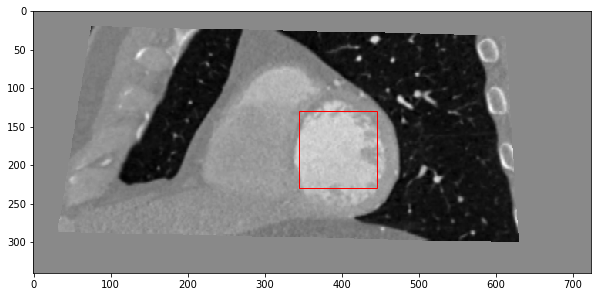

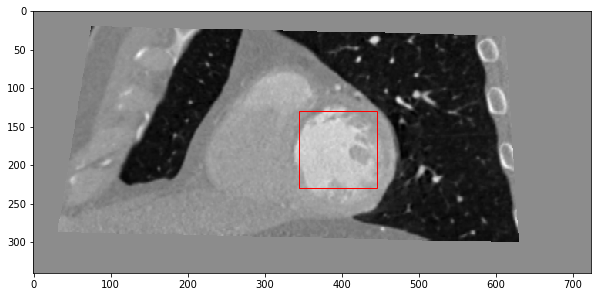

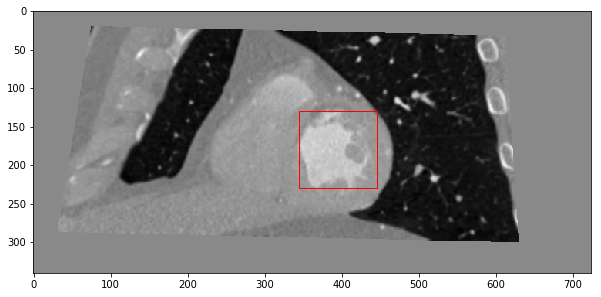

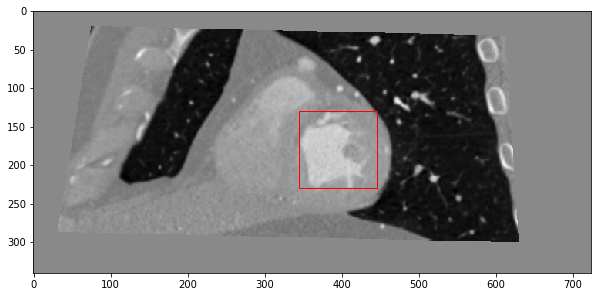

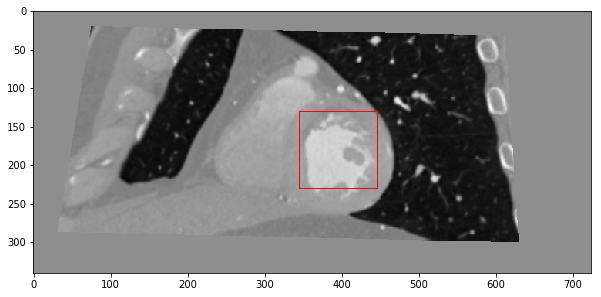

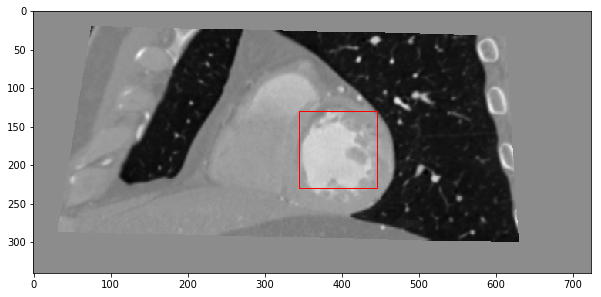

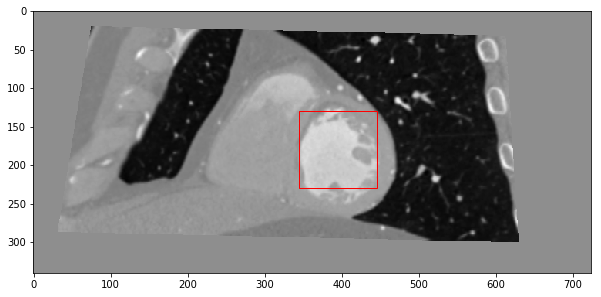

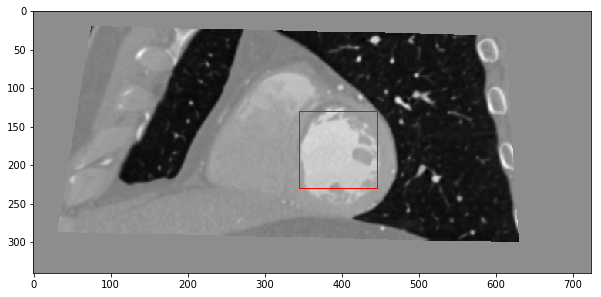

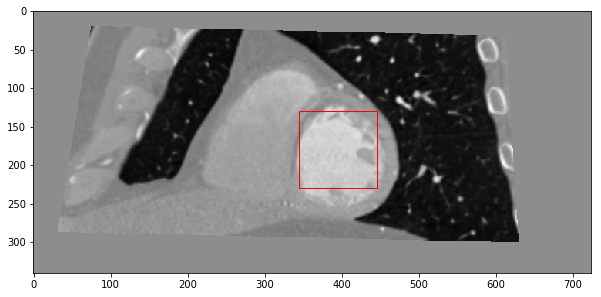

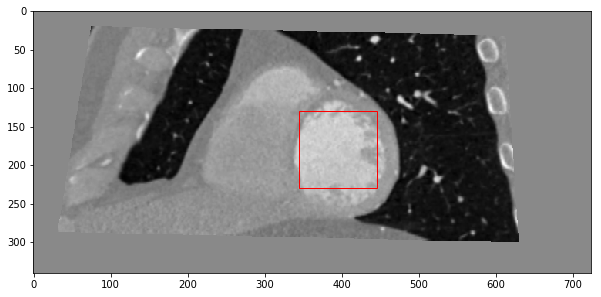

In [157]:
#Manualmente se obtuvieron los pixeles límite aproximados de los 4 bordes del rectángulo que engloba el ventrículo.
#Dichos pixeles se almacenan como diccionarios bajo la llave "area" del diccionario de cada paciente.
imgs_prueba1["area"] = {"x_min":345, "x_max":445, "y_min":130, "y_max":230}
imgs_prueba2["area"] = {"x_min":400, "x_max":470, "y_min":210, "y_max":300}
imgs_prueba3["area"] = {"x_min":375, "x_max":475, "y_min":350, "y_max":450}

#Se imprime una prueba del área propuesta sobre una serie de imágenes.
for i, imagen in enumerate(imgs_prueba1["imgs"]):
    fig, ax = plt.subplots(1)
    ax.imshow(imagen, cmap='gray')
    #Se crea un parche con el rectángulo que recubre el ventrículo
    rect = parches.Rectangle((imgs_prueba1["area"]["x_min"], imgs_prueba1["area"]["y_min"]),
                             imgs_prueba1["area"]["x_max"] - imgs_prueba1["area"]["x_min"],
                             imgs_prueba1["area"]["y_max"] - imgs_prueba1["area"]["y_min"], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

Obtención de parches y sus histograma promedio

In [158]:
def obtener_histogramas(img, area_interes, N = 10):
    histogramas = []
    histograma_promedio = []
    
    for i in range (0, N):
        #Se obtienen las filas y columnas correspondientes al rectángulo
        fila_min = randint(area_interes["y_min"], area_interes["y_max"]-9)
        col_min = randint(area_interes["x_min"], area_interes["x_max"]-9)
        fila_max = fila_min + 9
        col_max = col_min + 9

        #Se crea un shape con esas filas y columnas
        shape = img[fila_min:fila_max, col_min:col_max]

        #Se acumulan los histogramas de cada shape en una lista.
        histograma, bin_edges = np.histogram(shape.flatten(), bins = range(0, 257)) # tiene que ser 257 para que la contemple a los valores de 255
        histogramas.append(histograma)
    
    return histogramas, bin_edges

def obtener_histograma_promedio(img, area_interes, N = 10):
    histogramas, bin_edges = obtener_histogramas(img, area_interes, N)
    
    histograma_promedio = histogramas[0]
    
    for histograma in histogramas[1:]:
        histograma_promedio += histograma

    histograma_promedio = histograma_promedio / len(histogramas)
        
    return histograma_promedio, bin_edges

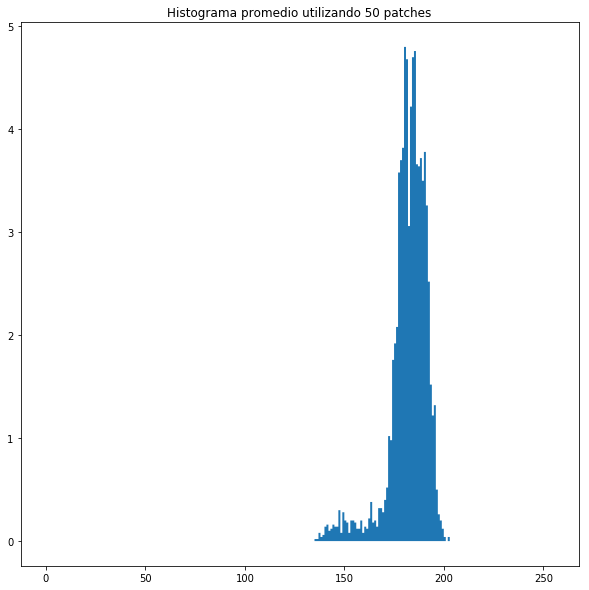

In [160]:
#Prueba de la función anterior.
#Se obtienen y grafican los histograma de los shapes de una imagen de prueba.
N = 50
histograma_promedio, bin_edges = obtener_histograma_promedio(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N)

plt.fill_between(bin_edges[:-1], histograma_promedio, step="pre")
plt.title("Histograma promedio utilizando {0} patches".format(N))
plt.show()

In [161]:
def distancia_chi2(hist1, hist2):
    """
    Función que calcula y regresa la distancia de chi cuadrada entre dos histogramas
    """
    suma = 0
    for bin1, bin2 in zip(hist1, hist2):
        if bin1 == 0 and bin2 == 0:
            pass
        else:
            suma += (((bin1 - bin2) ** 2) / (bin1 + bin2))
    return suma

def barrido_histogramas_imagen (imagen, histograma_promedio):
    """
    Función que recibe una imagen, un histograma y lo compara contra todos los histogramas de la imagen.
    """
    #Matriz que representa imagen de distancias
    img_distancias = np.zeros(shape=(imagen.shape[0], imagen.shape[1]))
    
    for i in range(imagen.shape[0] - 10):
        for j in range(imagen.shape[1] - 10):
            #Se genera una subimagen de 10x10 con un slice de la original.
            shape = imagen[i:i+9, j:j+9]
            #Se obtiene el histograma de esa subimagen
            histograma_shape, bin_edges = np.histogram(shape.flatten(), bins = range(0, 257))
            #Se obtiene la distancia chi entre histogramas y se pone como pixel en una imagen
            img_distancias[i,j] = distancia_chi2(histograma_promedio, histograma_shape)
            
    return img_distancias

Comparación de histogramas promedio de tres imágenes contra sus histogramas locales.

In [189]:
histograma_promedio, bin_edges = obtener_histograma_promedio(imgs_prueba1["imgs"][0], imgs_prueba1["area"], 50)
img_distancias1 = barrido_histogramas_imagen(imgs_prueba1["imgs"][0], histograma_promedio)

In [190]:
histograma_promedio, bin_edges = obtener_histograma_promedio(imgs_prueba2["imgs"][0], imgs_prueba2["area"], 50)
img_distancias2 = barrido_histogramas_imagen(imgs_prueba2["imgs"][0], histograma_promedio)

In [191]:
histograma_promedio, bin_edges = obtener_histograma_promedio(imgs_prueba3["imgs"][0], imgs_prueba3["area"], 50)
img_distancias3 = barrido_histogramas_imagen(imgs_prueba3["imgs"][0], histograma_promedio)

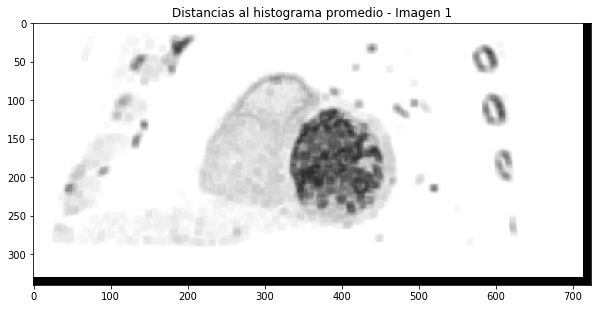

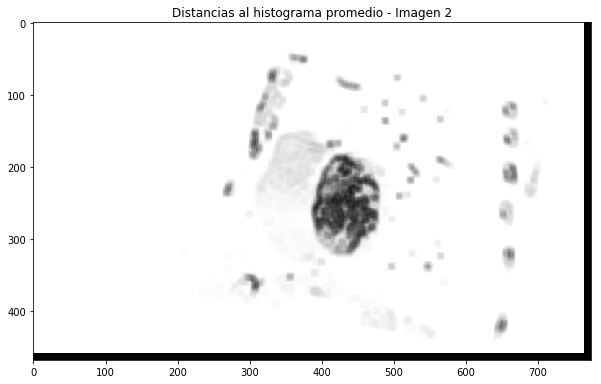

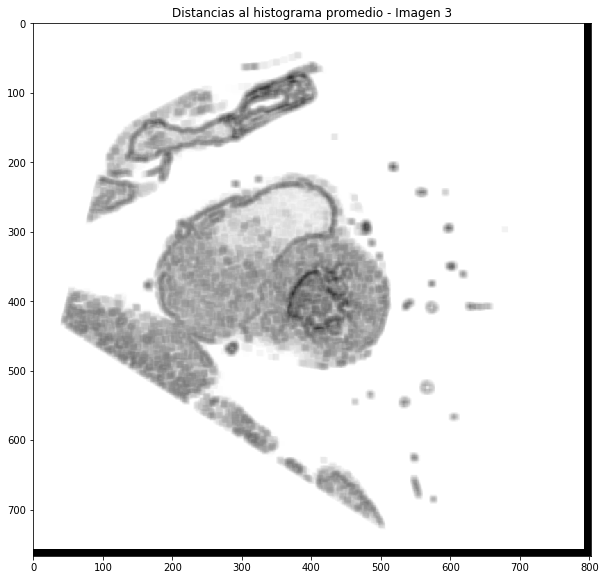

In [192]:
plt.imshow(img_distancias1, cmap='gray')
plt.savefig('resultados/B_01_distancias.png', bbox_inches='tight')
plt.title("Distancias al histograma promedio - Imagen 1")
plt.show()

plt.imshow(img_distancias2, cmap='gray')
plt.savefig('resultados/B_02_distancias.png', bbox_inches='tight')
plt.title("Distancias al histograma promedio - Imagen 2")
plt.show()

plt.imshow(img_distancias3, cmap='gray')
plt.savefig('resultados/B_03_distancias.png', bbox_inches='tight')
plt.title("Distancias al histograma promedio - Imagen 3")
plt.show()

Mejoramiento de la imagen de distancias obtenidas

In [181]:
#Función que aplica una máscara pixel por pixel a una imagen, resaltando los pixeles más oscuros.
def mascara (imagen):
    img_mascara = np.zeros(shape=(imagen.shape[0], imagen.shape[1]))
    
    #El umbral es 70% del pixel más brillante.
    max_val = np.amax(imagen)
    umbral = max_val * 0.5
    
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if imagen[i,j] > umbral:
                img_mascara[i,j] = max_val
            else:
                img_mascara[i,j] = 0
    return img_mascara

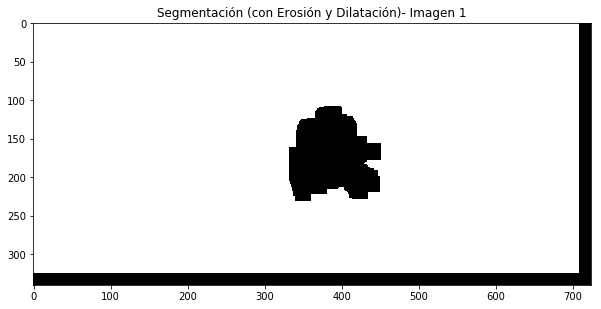

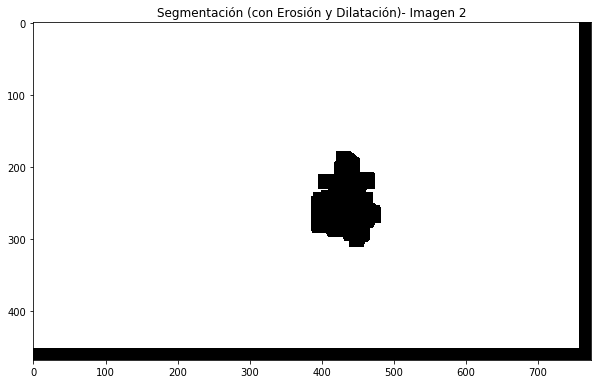

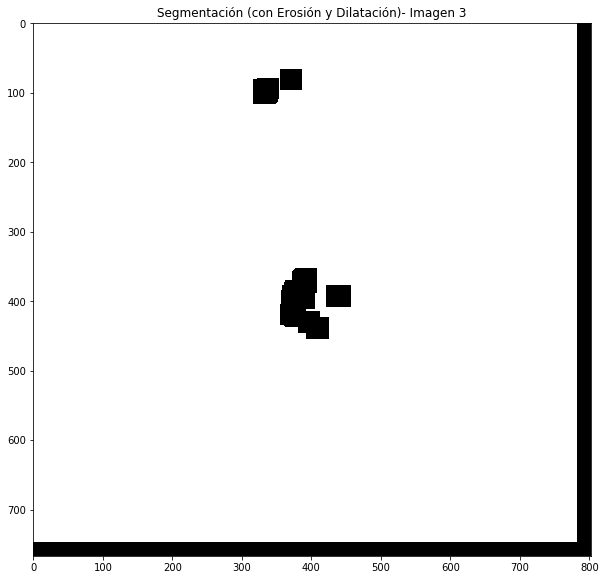

In [197]:
#Se aplica una máscara a las imágenes.
img_dist1_mejorada = mascara(img_distancias1)
img_dist2_mejorada = mascara(img_distancias2)
img_dist3_mejorada = mascara(img_distancias3)

#Erosión y dilatación de la imagen
kernel = np.ones((3, 3), np.uint8)
img_dist1_mejorada = cv2.dilate(img_dist1_mejorada, kernel, iterations = 5)
img_dist2_mejorada = cv2.dilate(img_dist2_mejorada, kernel, iterations = 4)
img_dist3_mejorada = cv2.dilate(img_dist3_mejorada, kernel, iterations = 5)

img_dist1_mejorada = cv2.erode(img_dist1_mejorada, kernel, iterations = 10)
img_dist2_mejorada = cv2.erode(img_dist2_mejorada, kernel, iterations = 10)
img_dist3_mejorada = cv2.erode(img_dist3_mejorada, kernel, iterations = 15)

#Impresión de las imágenes mejoradas.
plt.imshow(img_dist1_mejorada, cmap='gray')
plt.savefig('resultados/B_01_mejorada.png', bbox_inches='tight')
plt.title("Segmentación (con Erosión y Dilatación)- Imagen 1")
plt.show()

plt.imshow(img_dist2_mejorada, cmap='gray')
plt.savefig('resultados/B_02_mejorada.png', bbox_inches='tight')
plt.title("Segmentación (con Erosión y Dilatación)- Imagen 2")
plt.show()

plt.imshow(img_dist3_mejorada, cmap='gray')
plt.savefig('resultados/B_03_mejorada.png', bbox_inches='tight')
plt.title("Segmentación (con Erosión y Dilatación)- Imagen 3")
plt.show()

##### Obtención del vector de características y barrido de la imagen
En esta sección el objetivo es convertir el histograma de cada parche en un vector de características conformado con distintas estadísticas del histograma. Tomando aleatoriamente mucho parches de la zona de interés, se obtiene un vector promedio.

Después de hace un barrido sobre toda la imagen, sacando la distancia euclidiana entre el vector del parche con el que comienza cada pixel de la imagen, y el vector promedio.

In [198]:
def histogram2vector(histograma):
    """
    Recibe un histograma y lo convierte en un
    vector de características
    """
    
    # Por alguna razón se debe de hacer la siguientes 3 líneas:
    histograma = histograma / np.max(histograma)
    
    for i in range(histograma.shape[0]):
        histograma[i] *= i
        
    media = np.mean(histograma)
    varianza = np.var(histograma)
    momento2 = stats.moment(histograma, moment = 2)
    momento3 = stats.moment(histograma, moment = 3)
    momento4 = stats.moment(histograma, moment = 4)
    entropia = stats.entropy(histograma)
    return np.array([media, varianza, momento2, momento3, momento4, entropia])

def patch2vector(parche):
    """
    Recibe un parche y lo convierte en un vector
    de características.
    
    Por alguna razón no funciona para nuestros
    fines.
    """
    parche = parche.flatten()
    media = np.mean(parche)
    varianza = np.var(parche)
    momento2 = stats.moment(parche, moment = 2)
    momento3 = stats.moment(parche, moment = 3)
    momento4 = stats.moment(parche, moment = 4)
    entropia = stats.entropy(parche)
    return np.array([media, varianza, momento2, momento3, momento4, entropia])

In [199]:
def obtener_vector_promedio(img, area_interes, N = 10, TAM_PATCH = 15):
    vector_promedio = np.array([0]*7)
    histograma_promedio = np.zeros((256))
    for i in range (0, N):
        fila_min = randint(area_interes["y_min"], area_interes["y_max"] - TAM_PATCH - 1)
        col_min = randint(area_interes["x_min"], area_interes["x_max"] - TAM_PATCH - 1)
        fila_max = fila_min + TAM_PATCH
        col_max = col_min + TAM_PATCH

        patch = img[fila_min:fila_max, col_min:col_max]
        histograma, _ = np.histogram(patch.flatten(), bins = range(0, 257))
        # vec = histogram2vector(histograma)
        # vector_promedio = vector_promedio + vec
        histograma_promedio += histograma
        
    histograma_promedio = histograma_promedio / N
    vector_promedio = histogram2vector(histograma_promedio)
    return vector_promedio

def barrido_distancia_euclidiana(img, vector_promedio, TAM_PATCH = 15):
    distancia = np.zeros(img.shape)
    for i in range(img.shape[0] - TAM_PATCH):
        for j in range(img.shape[1] - TAM_PATCH):
            patch = img[i:i+TAM_PATCH, j:j+TAM_PATCH]
            histograma, _ = np.histogram(patch.flatten(), bins = range(0, 257))
            vec = histogram2vector(histograma/np.max(histograma))
            # vec = patch2vector(patch)
            dist = np.linalg.norm(vec - vector_promedio)
            distancia[i][j] = dist
    return distancia

Para hacer las pruebas primero tomamos el vector promedio de la zona de interés de una sola imagen, y hacemos el barrido sobre la misma imagen, y luego lo hacemos tomando el vector promedio a partir de diversas imágenes y hacemos el barrido sobre otra imagen.

###### Barrido con una sola imagen

In [238]:
vector_promedio = obtener_vector_promedio(imgs_prueba1["imgs"][0], imgs_prueba1["area"], 500)
print(vector_promedio)

[1.23273578e+01 1.35519437e+03 1.35519437e+03 1.69778942e+05
 2.49423142e+07 3.49714508e+00]


In [188]:
distancia_euc1 = barrido_distancia_euclidiana(imgs_prueba1["imgs"][0], vector_promedio)

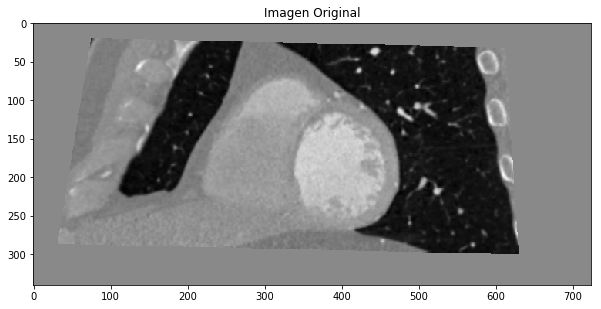

In [205]:
plt.imshow(imgs_prueba1["imgs"][0], cmap='gray')
plt.savefig('resultados/B_04_disteuc_1_original.png', bbox_inches='tight')
plt.title("Imagen Original")
plt.show()

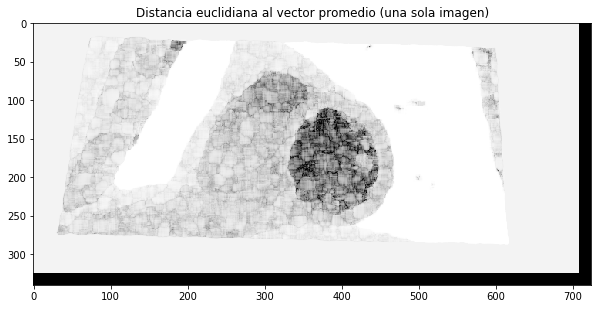

In [206]:
plt.imshow(distancia_euc1, cmap='gray')
plt.savefig('resultados/B_04_disteuc_2_distancias.png', bbox_inches='tight')
plt.title("Distancia euclidiana al vector promedio (una sola imagen)")
plt.show()

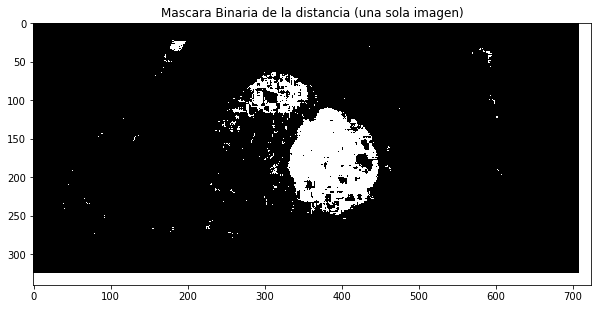

In [207]:
threshold = 15000000
plt.imshow(distancia_euc1 < threshold, cmap='gray')
plt.savefig('resultados/B_04_disteuc_3_threshold.png', bbox_inches='tight')
plt.title("Mascara Binaria de la distancia (una sola imagen)")
plt.show()

###### Barrido con varias imágenes

In [208]:
n_imags = 0
vector_promedio = np.zeros((6))
for img in imgs_prueba1["imgs"]:
    vector_promedio += obtener_vector_promedio(img, imgs_prueba1["area"], 10)
    n_imags += 1
    
for img in imgs_prueba2["imgs"]:
    vector_promedio += obtener_vector_promedio(img, imgs_prueba2["area"], 10)
    n_imags += 1
    
for img in imgs_prueba2["imgs"]:
    vector_promedio += obtener_vector_promedio(img, imgs_prueba2["area"], 10)
    n_imags += 1
    
for img in imgs_prueba3["imgs"]:
    vector_promedio += obtener_vector_promedio(img, imgs_prueba3["area"], 10)
    n_imags += 1
    
vector_promedio /= n_imags
    
print(vector_promedio)

[9.64356114e+00 8.60276224e+02 8.60276224e+02 9.99397602e+04
 1.42673709e+07 3.46981771e+00]


In [209]:
distancias_euc2 = barrido_distancia_euclidiana(imgs_prueba4["imgs"][8], vector_promedio)

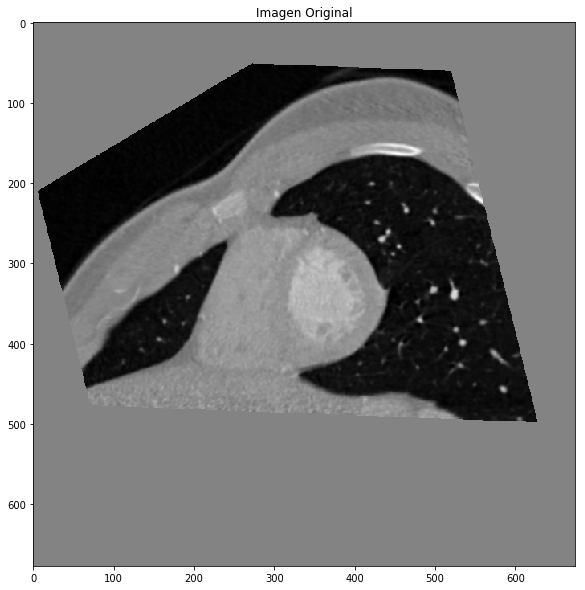

In [210]:
plt.imshow(imgs_prueba4["imgs"][8], cmap='gray')
plt.savefig('resultados/B_05_disteuc_1_original.png', bbox_inches='tight')
plt.title("Imagen Original")
plt.show()

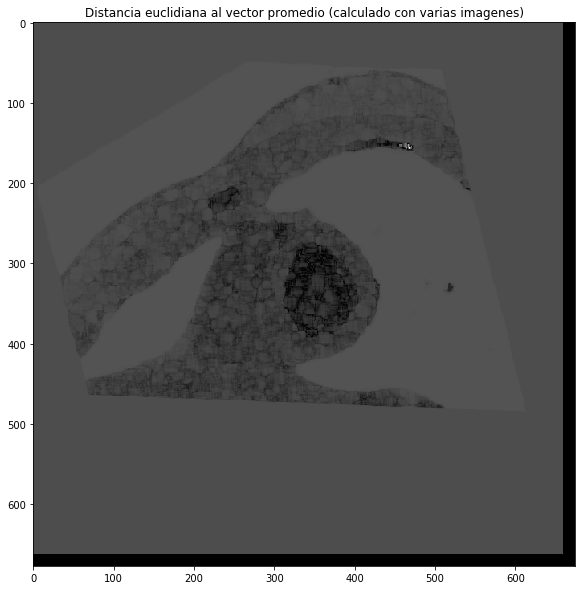

In [211]:
plt.imshow(distancias_euc2, cmap='gray')
plt.savefig('resultados/B_05_disteuc_2_distancias.png', bbox_inches='tight')
plt.title("Distancia euclidiana al vector promedio (calculado con varias imagenes)")
plt.show()

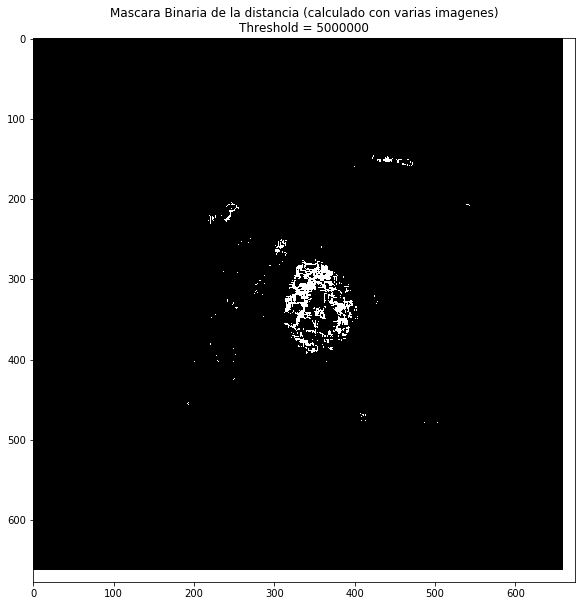

In [212]:
threshold = 5000000
plt.imshow(distancias_euc2 < threshold, cmap='gray')
plt.savefig('resultados/B_05_disteuc_3_threshold.png', bbox_inches='tight')
plt.title("Mascara Binaria de la distancia (calculado con varias imagenes)\nThreshold = {0}".format(threshold))
plt.show()

##### Clasificador de Bayes

Para utilizar el clasificador de bayes, es necesario formar un conjunto de datos que esten etiquetados como positivos (sí están en el área de interés) y como negativos (no están). Para ello se debe implementar una manera de obtener patches fuera del área de interés.

In [213]:
def obtener_pixel_afuera_del_area(img, area_interes, TAM_PATCH = 15):
    """
    Obtiene un punto aleatoriamente, afuera del area de interés
    que servirá como la esquina superior izquierda del patch
    
    Devuelve el rengón y la columna de dicho pixel.
    """
    img_height, img_width = img.shape
    img_width -= TAM_PATCH
    img_height -= TAM_PATCH
    rect_height = area_interes["y_max"] - area_interes["y_min"]
    rect_width = area_interes["x_max"] - area_interes["x_min"]
    
    max_id = (img_width*img_height) - (rect_width*rect_height)
    punto_id = randint(0, max_id - 1)
    
    c = punto_id % img_width
    r = punto_id // img_width
    
    if area_interes["y_min"] <= r < area_interes["y_max"] and area_interes["x_min"] <= c < area_interes["x_max"]:
        punto_id = max_id + (r - area_interes["y_min"])*rect_width + (c - area_interes["x_min"])
        c = punto_id % img_width
        r = punto_id // img_width
    
    return (r,c)   

def obtener_vectores_afuera_del_area(img, area_interes, N = 10, TAM_PATCH = 15):
    """
    Se obtiene una lista N vectores, obtenidos con el histograma
    de N patches sacados afuera del área de interés.
    
    :param img: imagen
    :param area_interes: area de interes
    :param N: numero de patches a analizar
    
    :return vectores: lista de N vectores obtenidos con los N patches
    """
    
    vectores = []
    
    for i in range (0, N):
        fila_min, col_min = obtener_pixel_afuera_del_area(img, area_interes, TAM_PATCH = TAM_PATCH)
        fila_max = fila_min + TAM_PATCH
        col_max = col_min + TAM_PATCH

        patch = img[fila_min:fila_max, col_min:col_max]
        histograma, _ = np.histogram(patch.flatten(), bins = range(0,257))
        vectores.append(histogram2vector(histograma))
        #vectores.append(patch2vector(patch))
    return vectores

def obtener_vectores_dentro_del_area(img, area_interes, N = 10, TAM_PATCH = 15):
    """
    Se obtiene una lista N vectores, obtenidos con el histograma
    de N patches sacados de dentro del área de interés.
    
    :param img: imagen
    :param area_interes: area de interes
    :param N: numero de patches a analizar
    
    :return vectores: lista de N vectores obtenidos con los N patches
    """
    
    vectores = []
    
    for i in range (0, N):
        fila_min = randint(area_interes["y_min"], area_interes["y_max"]-TAM_PATCH)
        col_min = randint(area_interes["x_min"], area_interes["x_max"]-TAM_PATCH)
        fila_max = fila_min + TAM_PATCH
        col_max = col_min + TAM_PATCH

        patch = img[fila_min:fila_max, col_min:col_max]
        histograma, _ = np.histogram(patch.flatten(), bins = range(0,257))
        vectores.append(histogram2vector(histograma))
        # vectores.append(patch2vector(patch))
        
    return vectores

def barrido_clasificador(img, clasificador, TAM_PATCH = 15):
    clasificacion = np.zeros(img.shape)
    for i in range(img.shape[0] - TAM_PATCH):
        for j in range(img.shape[1] - TAM_PATCH):
            patch = img[i:i+ TAM_PATCH, j:j+ TAM_PATCH]
            histograma, _ = np.histogram(patch.flatten(), bins = range(0, 257))
            vec = histogram2vector(histograma)
            # vec = patch2vector(patch)
            pred = clasificador.predict([vec])
            clasificacion[i][j] = np.asscalar(pred)
            
    return clasificacion

###### Probando la función de encontrar puntos fuera del área de interés

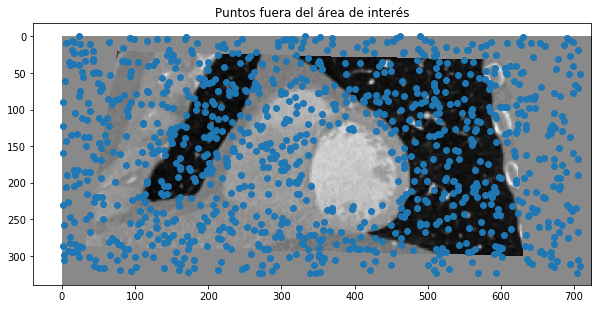

In [214]:
xs, ys = [], []
for _ in range(1000):
    p = obtener_pixel_afuera_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"])
    ys.append(p[0])
    xs.append(p[1])
    
plt.imshow(imgs_prueba1["imgs"][0], cmap='gray')
plt.scatter(xs, ys)
plt.title("Puntos fuera del área de interés")
plt.show()

###### Entrenando y probando con una misma imagen

In [215]:
vec_fuera = obtener_vectores_afuera_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = 500)
vec_dentro = obtener_vectores_dentro_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = 500)

X_train = vec_fuera + vec_dentro
y_train = [0]*len(vec_fuera) + [1]*len(vec_dentro)

In [218]:
gnb1 = GaussianNB()
gnb1.fit(X_train, y_train)

Ejemplo de predicción: [1]


In [219]:
muestra = 502
print("Ejemplo de predicción: clasifica a la muestra #{0} como {1}".format(muestra, gnb1.predict([X_train[502]])))

Ejemplo de predicción: clasifica a la muestra #502 como [1]


In [220]:
clasificacion_bayes1 = barrido_clasificador(imgs_prueba1["imgs"][0], gnb1)

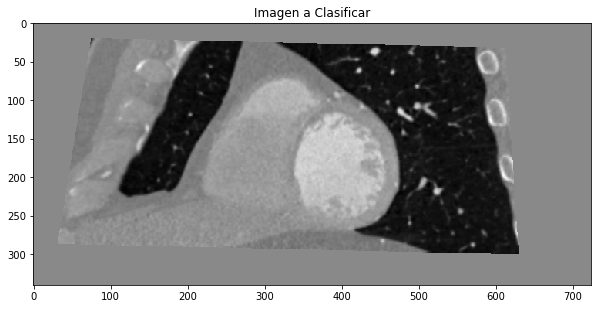

In [221]:
plt.imshow(imgs_prueba1["imgs"][0], cmap='gray')
plt.savefig('resultados/B_06_bayes1_1_original.png', bbox_inches='tight')
plt.title("Imagen a Clasificar")
plt.show()

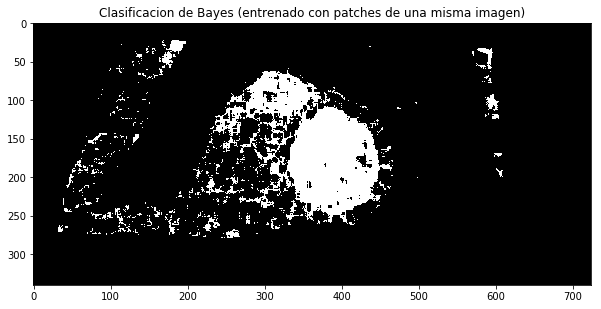

In [222]:
plt.imshow(clasificacion_bayes1, cmap= 'gray')
plt.savefig('resultados/B_06_bayes1_2_clasificacion.png', bbox_inches='tight')
plt.title("Clasificacion de Bayes (entrenado con patches de una misma imagen)")
plt.show()

###### Entrenando y probando con varias imágenes

In [225]:
X_train = []
y_train = []

N = 250
for img in imgs_prueba1["imgs"]:
    vec_fuera = obtener_vectores_afuera_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    vec_dentro = obtener_vectores_dentro_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    X_train += vec_fuera + vec_dentro
    y_train += [0]*len(vec_fuera) + [1]*len(vec_dentro)
    
for img in imgs_prueba2["imgs"]:
    vec_fuera = obtener_vectores_afuera_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    vec_dentro = obtener_vectores_dentro_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    X_train += vec_fuera + vec_dentro
    y_train += [0]*len(vec_fuera) + [1]*len(vec_dentro)
    
for img in imgs_prueba3["imgs"]:
    vec_fuera = obtener_vectores_afuera_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    vec_dentro = obtener_vectores_dentro_del_area(imgs_prueba1["imgs"][0], imgs_prueba1["area"], N = N)
    X_train += vec_fuera + vec_dentro
    y_train += [0]*len(vec_fuera) + [1]*len(vec_dentro)
    
print("Número de patches para entrenar:", len(X_train))

Número de patches para entrenar: 13500


In [227]:
gnb2 = GaussianNB()
gnb2.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [228]:
clasificacion_bayes2 = barrido_clasificador(imgs_prueba4["imgs"][8], gnb2)

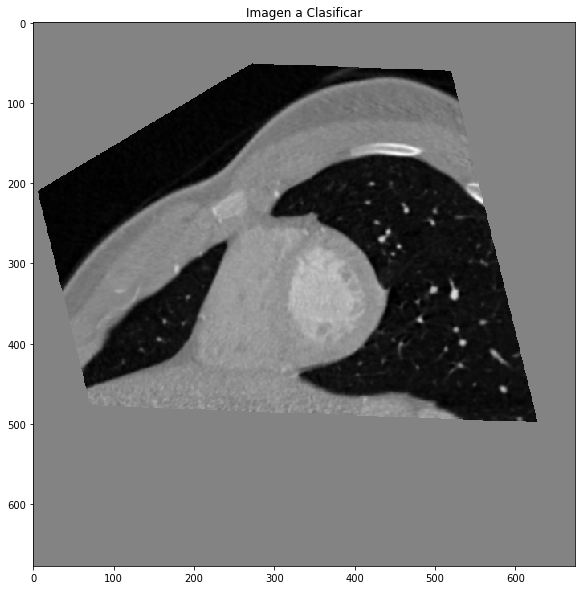

In [229]:
plt.imshow(imgs_prueba4["imgs"][8], cmap='gray')
plt.savefig('resultados/B_07_bayes2_1_original.png', bbox_inches='tight')
plt.title("Imagen a Clasificar")
plt.show()

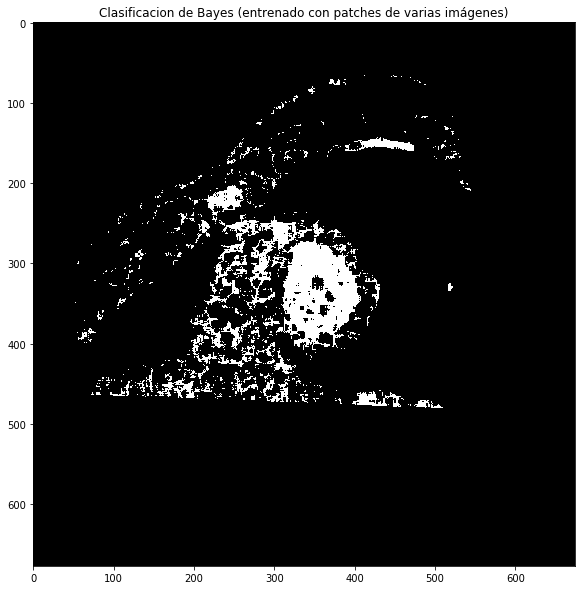

In [231]:
plt.imshow(clasificacion_bayes2, cmap= 'gray')
plt.savefig('resultados/B_07_bayes2_2_clasif.png', bbox_inches='tight')
plt.title("Clasificacion de Bayes (entrenado con patches de varias imágenes)")
plt.show()

###### Probando con clasificador SVM

In [232]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [233]:
clasificacion_svm = barrido_clasificador(imgs_prueba4["imgs"][8], clf)

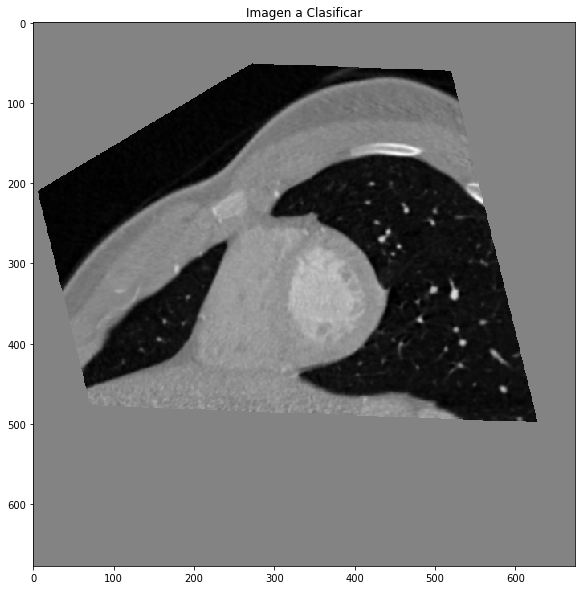

In [234]:
plt.imshow(imgs_prueba4["imgs"][8], cmap='gray')
plt.savefig('resultados/B_08_svm_1_original.png', bbox_inches='tight')
plt.title("Imagen a Clasificar")
plt.show()

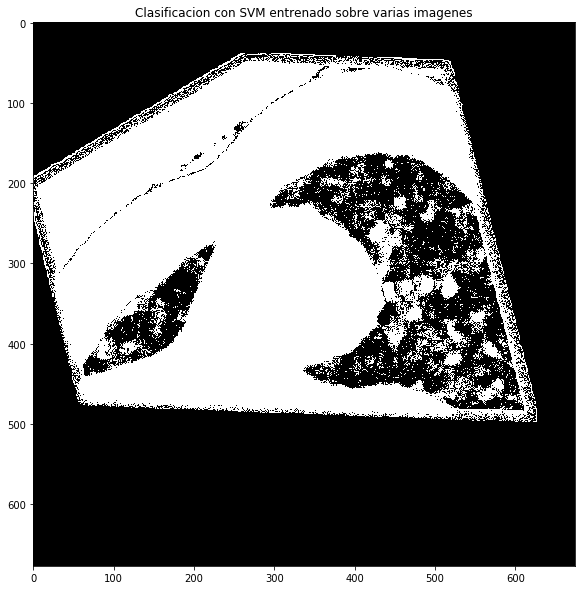

In [235]:
plt.imshow(clasificacion_svm, cmap = 'gray')
plt.savefig('resultados/B_08_svm_2_clasif.png', bbox_inches='tight')
plt.title("Clasificacion con SVM entrenado sobre varias imagenes")
plt.show()

### Conclusiones
* La ecualización local de histogramas puede ser muy tardada, pero permite revelar aspectos de la imagen que no se pueden ver a simple vista.
* Hacer una segmentacíón por distancia de histogramas da muy buenos resultados. Sin embargo, el proceso es muy tardado y la imagen resultante puede no ser muy clara, por lo que es recomendable filtrar adicionalmente el resultado.
* Al utilizar un vector de características calculado sobre el histograma local para clasificar cada pixel, resulta mejor utilizar la distancia euclidiana entre dicho vector y un vector promedio de la clase que nos interesa. Utilizar un clasificador como el bayesiano, o el SVM, no nos dió tan buenos resultados.
* Quizás de ser más precisos en la selección de las áreas de interés en cada imagen, obtendríamos mejores resultados en general.
 
### Fuentes
* Gozález R., Woods R. Digital Image Processing, 3a edición 